# Run 'stockread.py' once every weekday. 
## It may take up to an hour to download data 
## (depending on net speed)

In [22]:
import sys
!python3 stockreader.py

Log file name : ./logs/log_2020-Mar-02-17-38-16.txt
andv data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Skipped
andv data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Skipped
andv data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Skipped
andv data.dict Empty ERROR -- Skipped
bf.b data.dict Empty ERROR -- Skipped
brk.b data.dict Empty ERROR -- Skipped
ggp data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Skipped
ggp data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Ski

# Import stockdatalib

In [39]:
import stockdatalib as sd

# Must set the data subdirectory

In [40]:
# Set the data directory and the stock name
sd.set_data_directory('./data/')

# Load Data and plot a stock

<Figure size 1080x432 with 0 Axes>

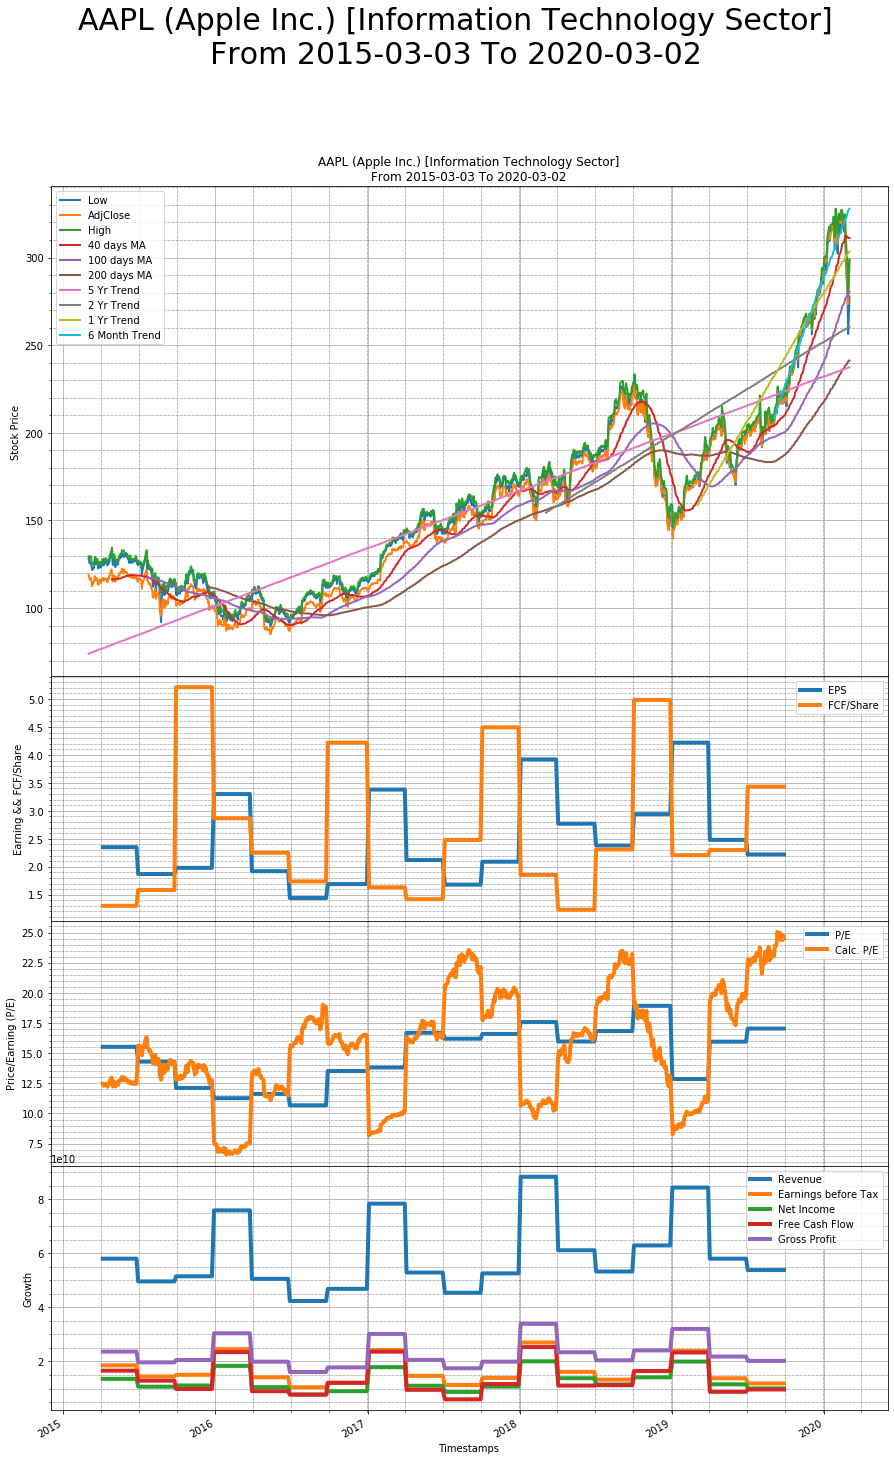

In [41]:
# Load S&P Stock list
stock_count, stock_fields, sp_df = sd.GetSP500_List()

# Set stock symbol
sd.set_stock('aapl')

stock_info = sd.get_stock_info('aapl')
# Get stock company information
company_name = stock_info['name'][0]
company_sector = stock_info['sector'][0]

# Plot stock basic charts
linear_trends = sd.plot_basic_charts('aapl')

In [42]:
# Linear Regression Equations returned by the plot call
linear_trends

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.1299 x + 73.93,0.2117 x + 154.4,0.5764 x + 158.7,0.9663 x + 208


In [43]:
# Get last price quote
sd.quote('csco')

,symbol,date,close,volume
0,csco,2020-03-02 21:00:01,41.17,46581395


In [44]:
# Get last key stats on the stock
sd.key_stat('ibm')

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,ibm,2019-09-30,887291199.0,1.802800e+10,1.522000e+09,16.7728,1.88,1.672000e+09,0.168127,8.335000e+09,3.597


,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,1.412 x + 279.5,0.5578 x + 1625,0.3382 x + 1801,2.242 x + 1701


<Figure size 1080x432 with 0 Axes>

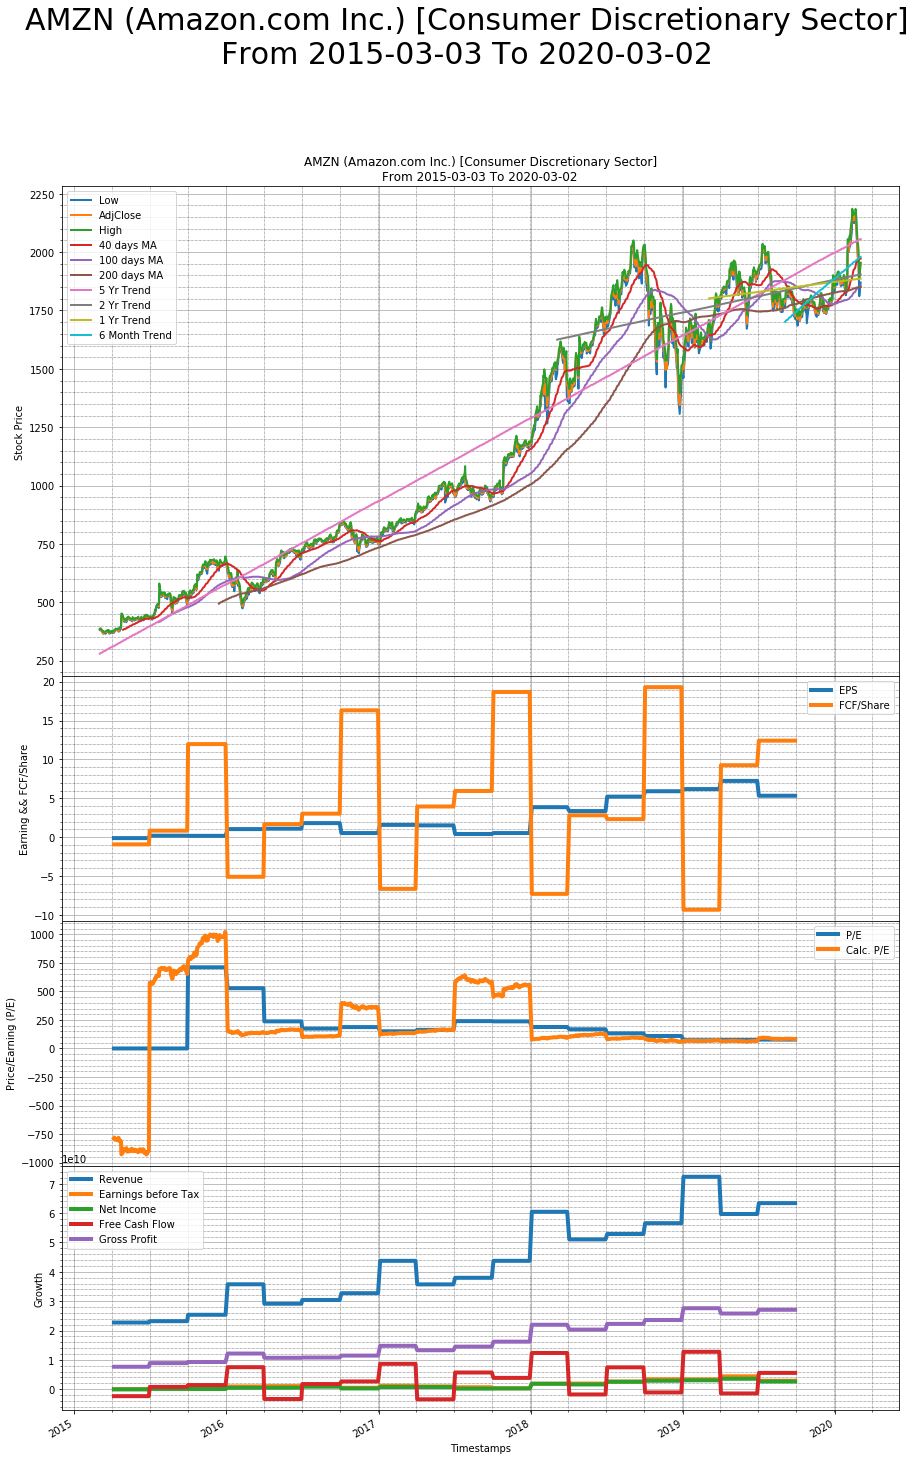

In [45]:
# Plot another stock
sd.plot_basic_charts('amzn')

# The data load functions

In [46]:
# Load stock End of Day prices file
price_df = sd.GetStockDataFrame('fb')

# Index the data frame by 'Timestamps' column
price_df.set_index('Timestamps',inplace=True)

# Load the stock fundamental data
keys, column_map, main_df_org = sd.GetFund_Dict('fb')

# Searching for data by column name

In [47]:
# Search for a key word in the data column names
table,text = sd.FindColumn('Revenue')
table

,column_name,DataFrame
0,Revenue,income-statement
1,Revenue Growth,income-statement
2,Cost of Revenue,income-statement
3,Deferred revenue,balance-sheet-statement
4,Revenue per Share,company-key-metrics
5,SG&A to Revenue,company-key-metrics
6,R&D to Revenue,company-key-metrics
7,Capex to Revenue,company-key-metrics
8,Stock-based compensation to Revenue,company-key-metrics
9,profitabilityIndicatorRatios_eBITperRevenue,financial-ratios


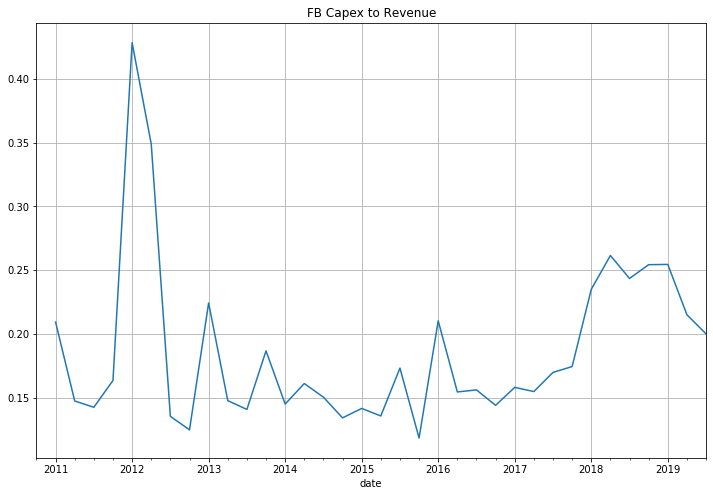

In [48]:
# Now we know where 'Capex to Revenue' is, we can load it from the DataFrame source 'company-key-metrics' as 
# the code below
main_df_org['company-key-metrics']['Capex to Revenue'].plot(figsize=(12,8),
                                                            grid=True, 
                                                            title=sd.get_stock().upper()+' Capex to Revenue')

# Selecting data range from price data frame

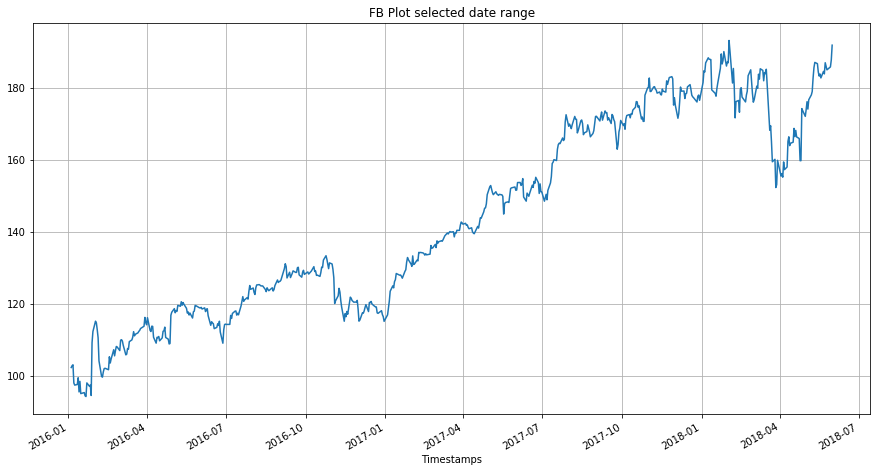

In [49]:
# Limit the stock prices data in the dates range
price_df = sd.DatesRange(price_df, '2016-01-01', '2018-06-01')

# Plot the prices chart
ax1 = price_df['AdjClose'].plot(figsize=(15,8),
                                title=sd.get_stock().upper()+" Plot selected date range").grid()

# Merging DataFrames from multiple sources into one DF

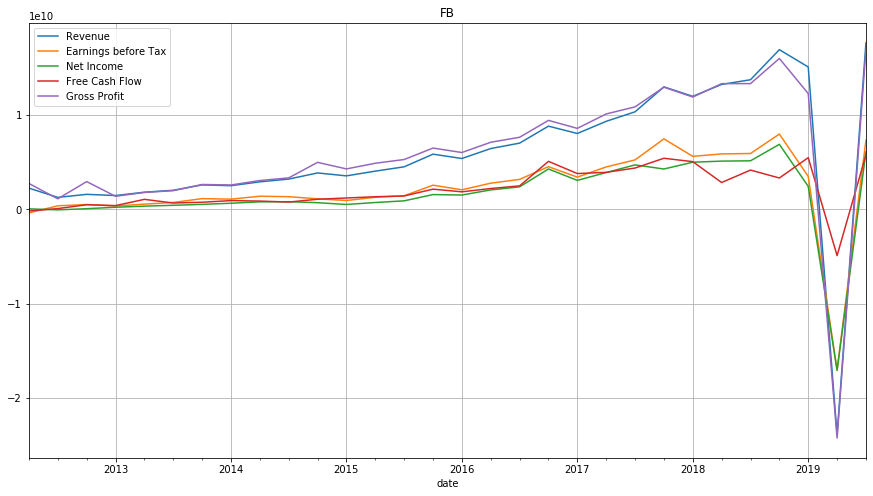

In [50]:
import pandas as pd

# Create a subset of columns in a DataFrame from the stock fundamentals dataset
cols = ['Revenue','Earnings before Tax','Net Income','Free Cash Flow margin','Gross Profit','Net Profit Margin'] # [ 'Shares', 'Price', 'Revenue', 'Earnings']
main_df1 = sd.MakeFund_Subset(main_df_org['income-statement'],cols)

# Create another subset of columns from another fundamentals dataset
cols = ['Number of Shares','Stock Price']
main_df2 = sd.MakeFund_Subset(main_df_org['enterprise-value'],cols)

# Create a 3rd subject of columns from yet another fundamentals dataset
cols = ['Capital Expenditure','Free Cash Flow']
main_df3 = sd.MakeFund_Subset(main_df_org['cash-flow-statement'],cols)

# Create a 4th subject of columns from yet another fundamentals dataset
cols = ['Free Cash Flow per Share']
main_df4 = sd.MakeFund_Subset(main_df_org['company-key-metrics'],cols)


# Merge the 3 dataframes into a single dataframe
main_df = pd.merge(main_df1,main_df2,on='date')
main_df = pd.merge(main_df,main_df3,on='date')
main_df = pd.merge(main_df,main_df4,on='date')

main_df.plot(y=['Revenue','Earnings before Tax','Net Income','Free Cash Flow','Gross Profit'],
             figsize=(15,8),title=sd.get_stock().upper()).grid()


# Using DatesRange() on fundamental data 

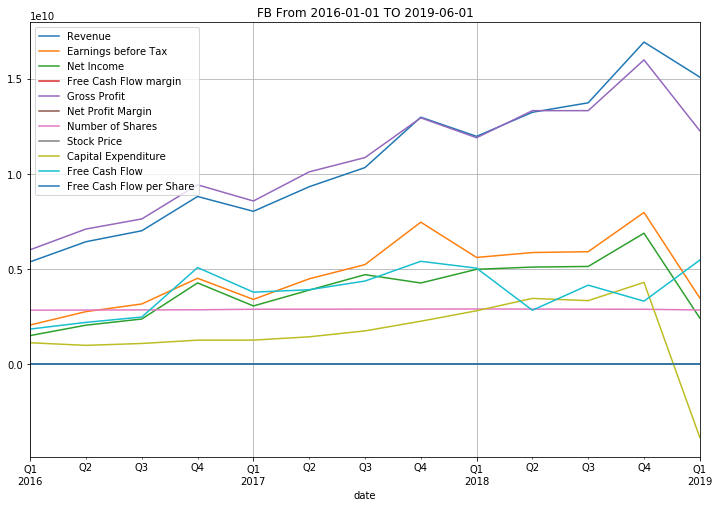

In [51]:
sd.DatesRange(main_df, '2016-01-01', '2019-06-01').plot(figsize=(12,8),
                                                                     grid=True,
                                                                     title=sd.get_stock().upper()+' From 2016-01-01 TO 2019-06-01')

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.2684 x + 42.12,-0.03652 x + 341.8,-0.1604 x + 351.6,0.8935 x + 258.3


<Figure size 1080x432 with 0 Axes>

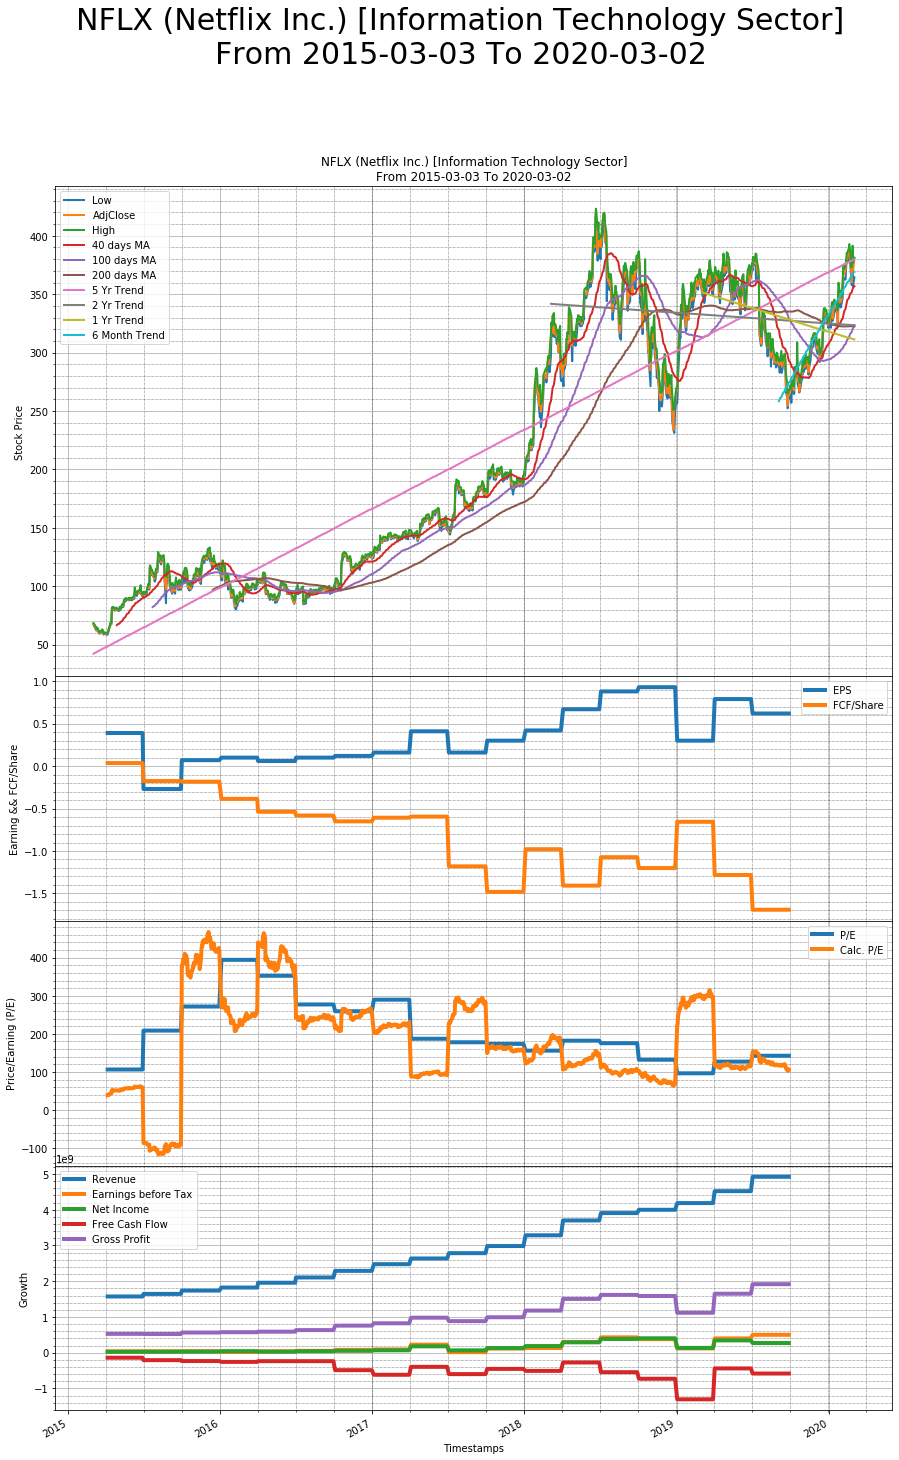

In [52]:
# Plot price chart with trend lines, EPS, and PE ratios
sd.plot_basic_charts('nflx')

# Plot a single key stat item

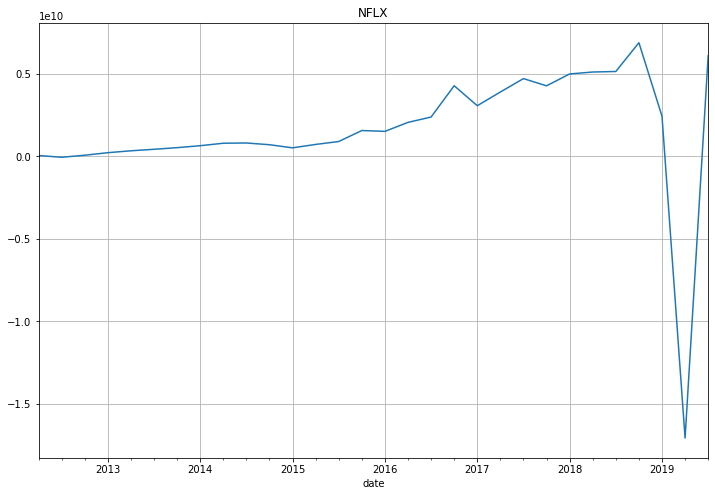

In [53]:
main_df['Net Income'].plot(figsize=(12,8), title = sd.get_stock().upper()).grid()

# Plot the TrendChart()

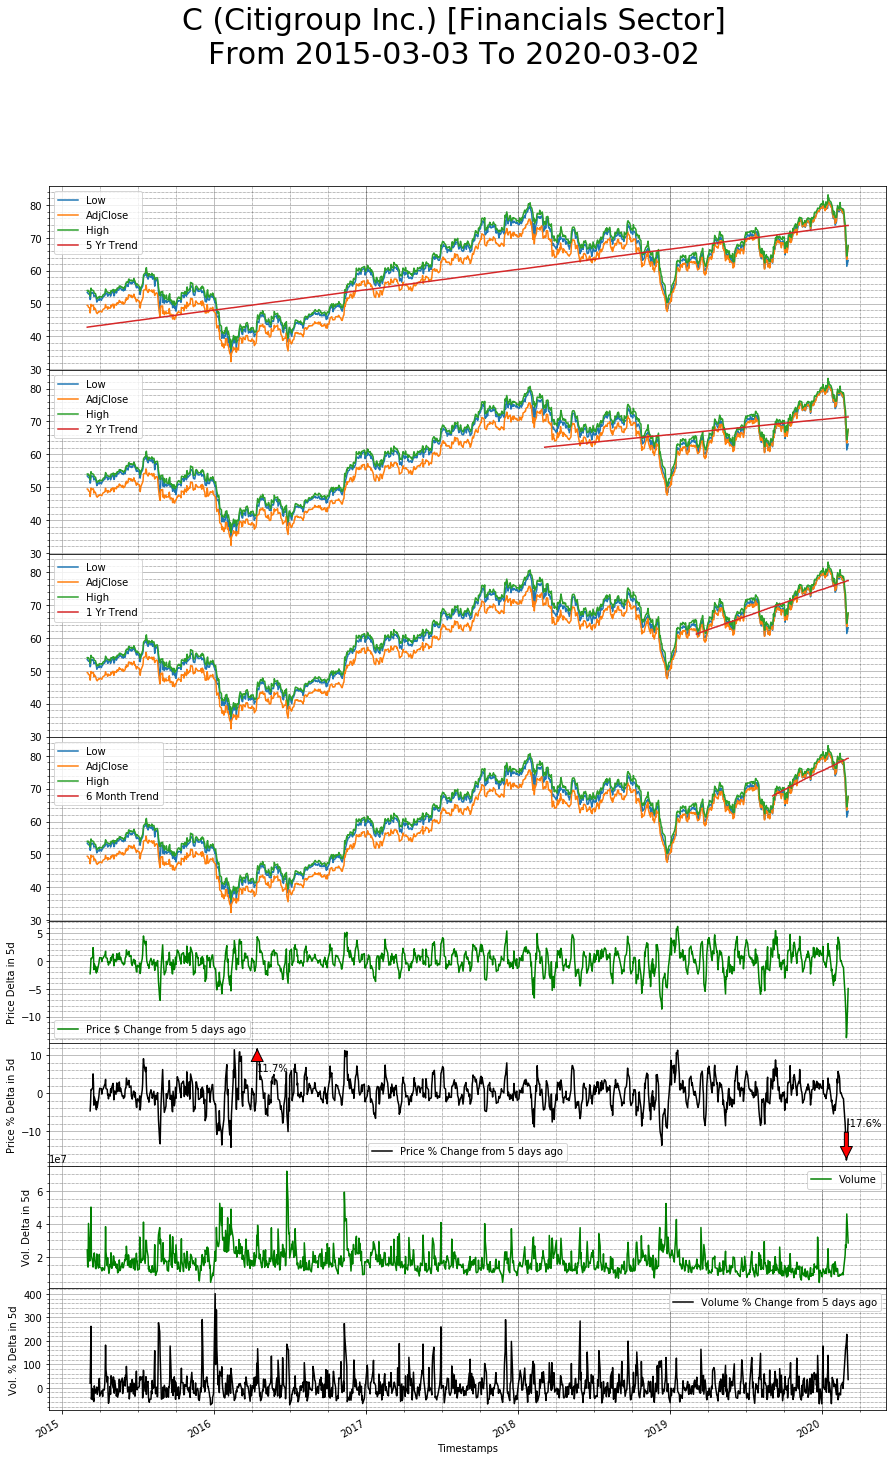

In [54]:
price_data_df, maximums_table_df = sd.TrendsPlot('c')

# Show the Maximums Table in price and volume

In [55]:
maximums_table_df

,Date,Price,Volume
Change Type,,,
Max % Rise,2016-04-14,11.7%,--
Max % Drop,2020-02-27,-17.6%,--
Max % Rise,2016-01-04,--,401.8%
Max % Drop,2016-07-01,--,-73.0%


In [56]:
price_data_df.describe()

,Open,High,Low,AdjClose,Volume,Price $ Change from 5 days ago,Price % Change from 5 days ago,Volume % Change from 5 days ago,5 Yr Trend,2 Yr Trend,1 Yr Trend,6 Month Trend
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1254.000000,1254.000000,1254.000000,1259.000000,502.000000,252.000000,125.000000
mean,61.389531,61.966886,60.819635,58.297850,1.755157e+07,0.069683,0.188127,10.100150,58.297850,66.768129,69.293455,73.514819
std,10.718919,10.761796,10.680333,11.168404,7.224638e+06,2.083244,3.640062,53.023233,8.945505,2.665265,4.725249,3.344154
min,36.000000,36.160000,34.520000,32.323948,4.576200e+06,-13.770004,-17.604198,-72.999786,42.822233,62.165532,61.157687,67.791758
25%,53.145000,53.664999,52.715000,49.169205,1.276195e+07,-0.953207,-1.621416,-24.286034,50.560041,64.466830,65.225571,70.653289
50%,62.849998,63.660000,61.970001,60.572556,1.581690e+07,0.166376,0.310701,0.357770,58.297850,66.768129,69.293455,73.514819
75%,70.099998,70.744999,69.410000,67.561653,2.039955e+07,1.294963,2.305861,27.659745,66.035659,69.069427,73.361338,76.376349
max,81.959999,83.110001,80.970001,81.370491,7.184980e+07,6.211060,11.696050,401.802535,73.773467,71.370725,77.429222,79.237880


# Search for a column containing 'cash flow' substring

In [57]:
f,s = sd.FindColumn('cash flow')
f

,column_name,DataFrame
0,Free Cash Flow margin,income-statement
1,Operating Cash Flow,cash-flow-statement
2,Investing Cash flow,cash-flow-statement
3,Financing Cash Flow,cash-flow-statement
4,Net cash flow / Change in cash,cash-flow-statement
5,Free Cash Flow,cash-flow-statement
6,Operating Cash Flow per Share,company-key-metrics
7,Free Cash Flow per Share,company-key-metrics
8,EV to Operating cash flow,company-key-metrics
9,EV to Free cash flow,company-key-metrics
